In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# Set seed value
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load dataset 
data = yf.download('AMZN', start='2015-02-08', end='2025-02-08')
data = data[['Close']]
data.dropna(inplace=True)
# Keep a copy for plotting
data_plot = data.copy()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Check for missing values
print(data.isnull().sum())

Price  Ticker
Close  AMZN      0
dtype: int64


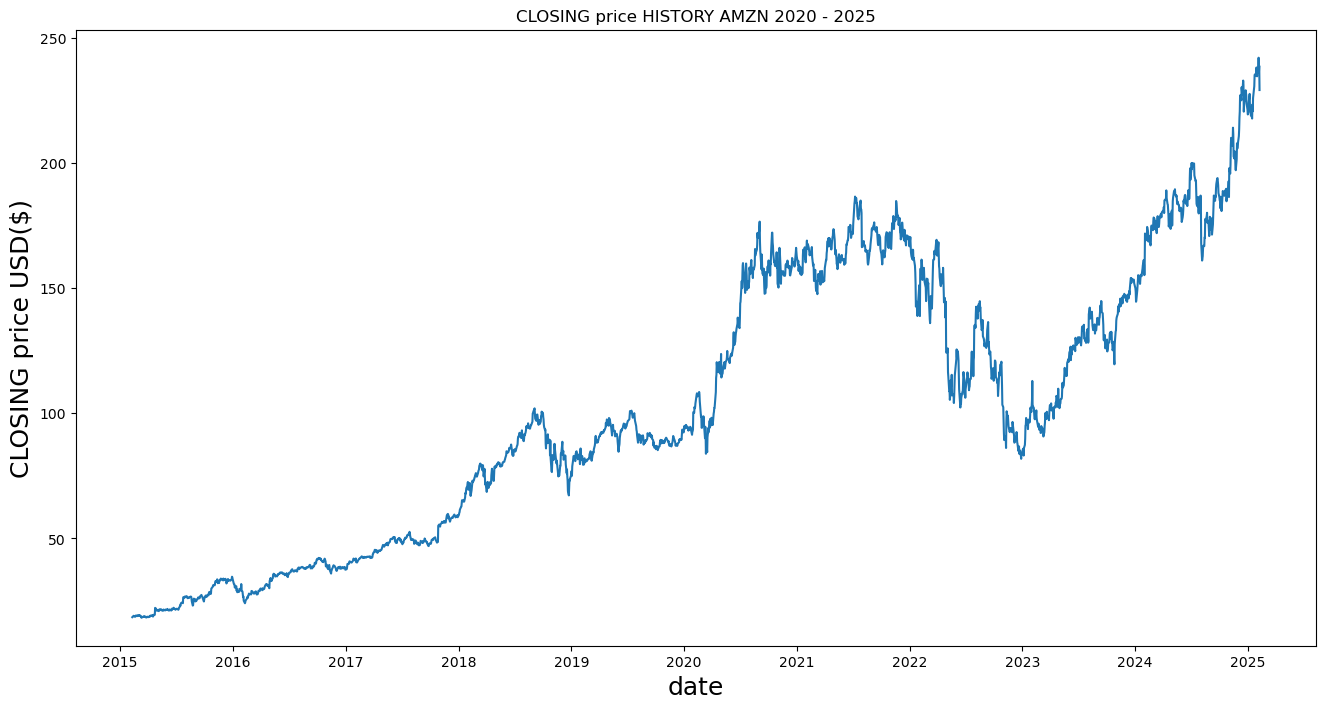

In [5]:
plt.figure(figsize=(16,8))
plt.title('CLOSING price HISTORY AMZN 2020 - 2025')
plt.plot(data['Close'])
plt.xlabel('date',fontsize=18)
plt.ylabel('CLOSING price USD($)',fontsize=18)
plt.show()

### DATA SPLITTING

In [7]:
data = data[['Close']].values
training_data_len = math.ceil(len(data) * 0.8)

In [8]:
train_data = data[:training_data_len]
test_data = data[training_data_len:]

### DATA SCALING

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

### SEQUENCES

In [12]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set time steps (lookback window)
time_steps = 30

# Create training sequences
X_train, y_train = create_sequences(scaled_train_data, time_steps)

# Create test sequences
# Combine last 30 points of training data with test data for proper sequencing
scaled_full_data = np.concatenate([scaled_train_data, scaled_test_data])
X_test, y_test = create_sequences(scaled_full_data[len(scaled_train_data)-time_steps:], time_steps)

### RESHAPE

In [14]:
# Reshape 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1983, 30, 1)
Test data shape: (503, 30, 1)


## LSTM MODEL

In [16]:
lstm_model = Sequential()

# First LSTM layer with dropout
lstm_model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.1))

# Second LSTM layer with dropout
lstm_model.add(LSTM(32, return_sequences=False))
lstm_model.add(Dropout(0.1))

# Output layer
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
lstm_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0025
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0198
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0212
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0199
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0189
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0184
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0098
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0226
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0079
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013  
E

### LSTM PREDICTIONS

In [19]:
# Predict
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
r2 = r2_score(y_test_actual, lstm_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
RMSE: 15.8425
R² Score: 0.8235


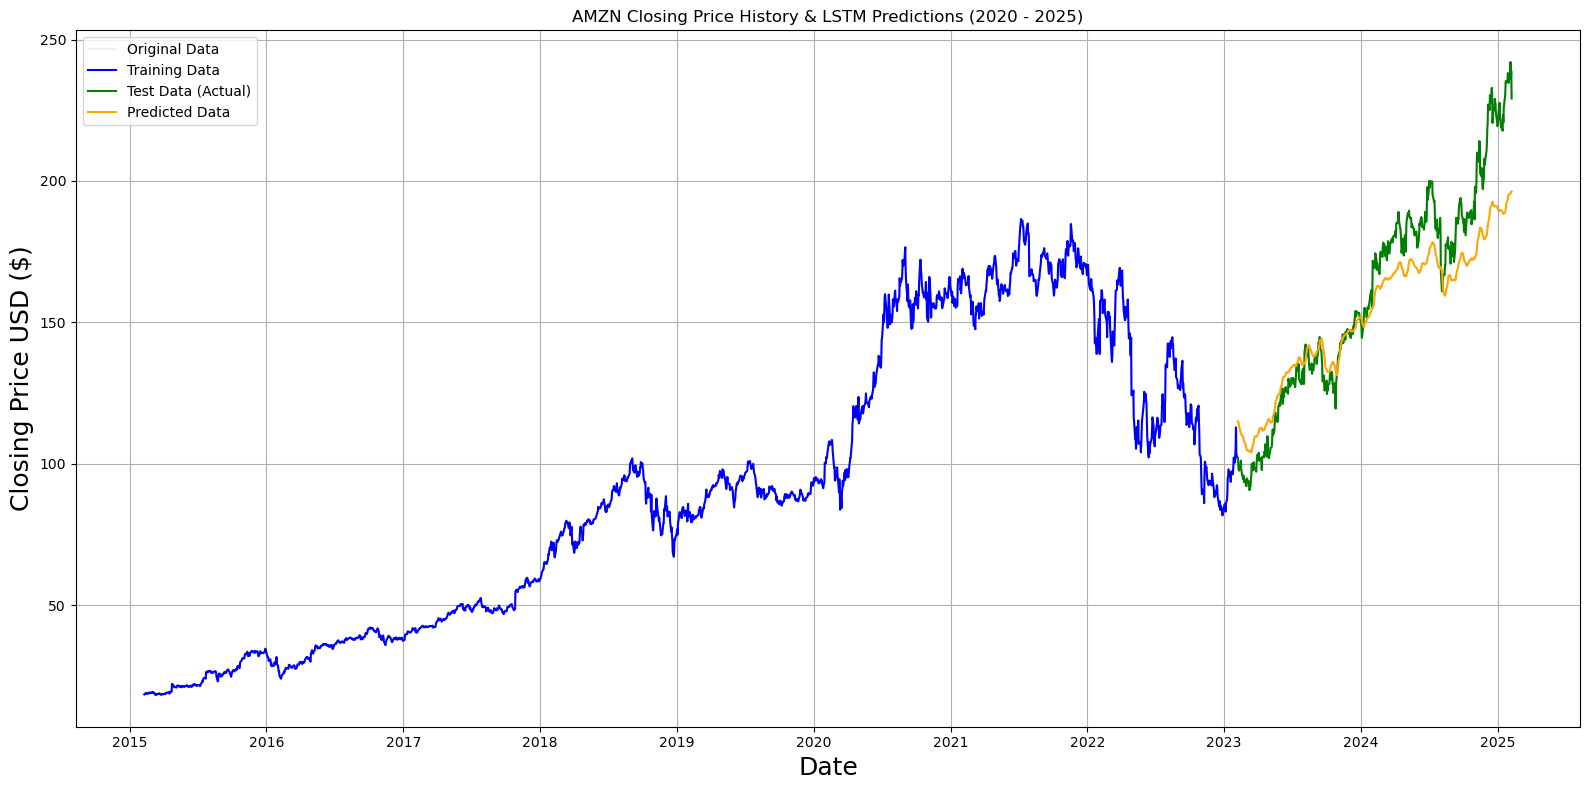

In [20]:
plt.figure(figsize=(16, 8))
plt.title('AMZN Closing Price History & LSTM Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, lstm_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## GRU MODEL

In [22]:
gru_model = Sequential()

# First GRU layer with dropout
gru_model.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.1))

# Second GRU layer with dropout
gru_model.add(GRU(32, return_sequences=False))
gru_model.add(Dropout(0.1))

# Output layer
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
gru_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0012
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0079
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0084
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0105
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0100
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0104
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0128
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0125
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0109
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0104
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0077
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0052
Epo

### GRU PREDICTIONS

In [25]:
# Predict
gru_predictions = gru_model.predict(X_test)

# Inverse transform
gru_predictions = scaler.inverse_transform(gru_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, gru_predictions))
r2 = r2_score(y_test_actual, gru_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")    

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
RMSE: 13.0535
R² Score: 0.8801


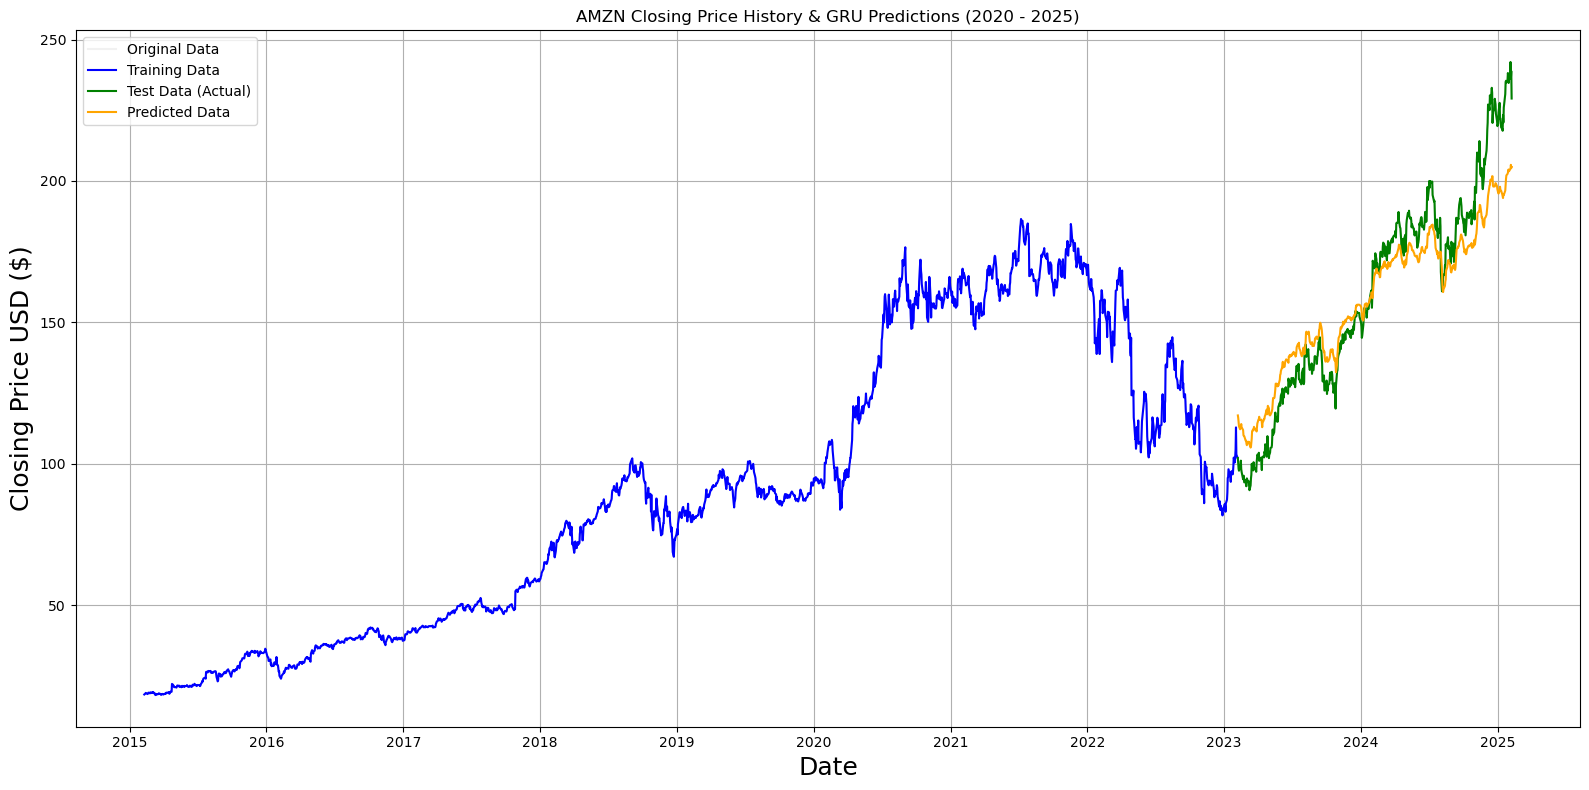

In [26]:
plt.figure(figsize=(16, 8))
plt.title('AMZN Closing Price History & GRU Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, gru_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LSTM-GRU MODEL

In [28]:
lstm_gru_model = Sequential()

# First LSTM layer with dropout
lstm_gru_model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_gru_model.add(Dropout(0.1))

# Second GRU layer with dropout
lstm_gru_model.add(GRU(32, return_sequences=False))
lstm_gru_model.add(Dropout(0.1))

# Output layer
lstm_gru_model.add(Dense(1))

lstm_gru_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_gru_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,721 (41.88 KB)

 Trainable params: 10,721 (41.88 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
lstm_gru_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0020
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0125
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0164
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0161
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0169
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0144
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0132
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0075
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0055
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0059
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0060
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0084
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0490
Epo

### LSTM-GRU PREDICTIONS

In [31]:
# Predict
lstm_gru_predictions = lstm_gru_model.predict(X_test)

# Inverse transform
lstm_gru_predictions = scaler.inverse_transform(lstm_gru_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_gru_predictions))
r2 = r2_score(y_test_actual, lstm_gru_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")   

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
RMSE: 14.3132
R² Score: 0.8559


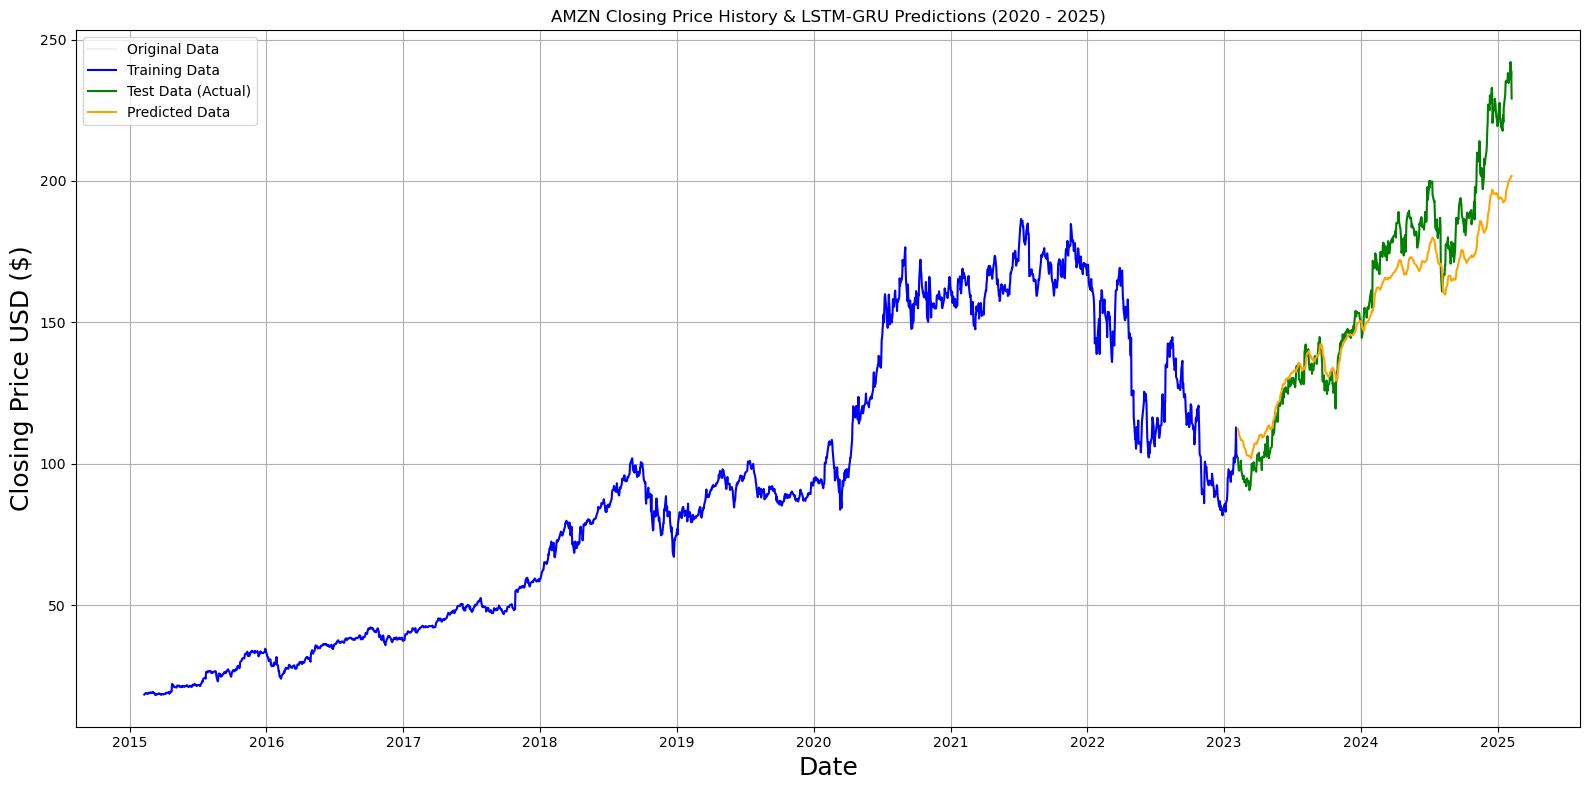

In [32]:
plt.figure(figsize=(16, 8))
plt.title('AMZN Closing Price History & LSTM-GRU Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, lstm_gru_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### GRU-LSTM MODEL

In [34]:
gru_lstm_model = Sequential()

# First GRU layer with dropout
gru_lstm_model.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_lstm_model.add(Dropout(0.1))

# Second LSTM layer with dropout
gru_lstm_model.add(LSTM(32, return_sequences=False))
gru_lstm_model.add(Dropout(0.1))

# Output layer
gru_lstm_model.add(Dense(1))

gru_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

gru_lstm_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 30, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,713 (45.75 KB)

 Trainable params: 11,713 (45.75 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
gru_lstm_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0020
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0070
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0146
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0136
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0157
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0170
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0167
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0171
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0115
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0067
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012    
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011

### GRU-LSTM PREDICTIONS

In [37]:
# Predict
gru_lstm_predictions = gru_lstm_model.predict(X_test)

# Inverse transform
gru_lstm_predictions = scaler.inverse_transform(gru_lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, gru_lstm_predictions))
r2 = r2_score(y_test_actual, gru_lstm_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")  

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
RMSE: 13.6489
R² Score: 0.8690


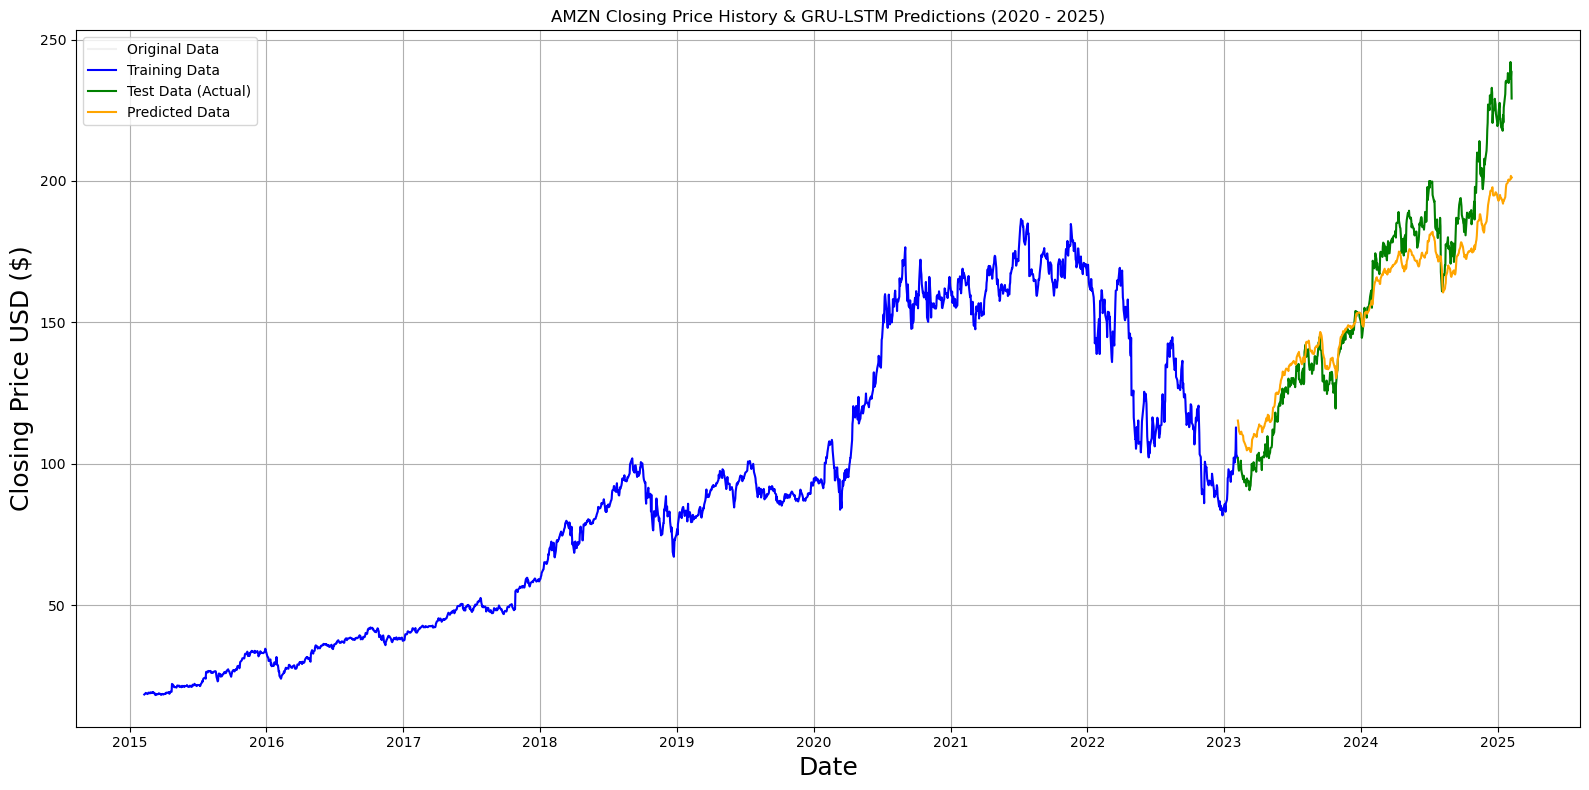

In [38]:
plt.figure(figsize=(16, 8))
plt.title('AMZN Closing Price History & GRU-LSTM Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, gru_lstm_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

### LSTM TUNING

In [41]:
# ---------------------------
# Define LSTM model builder
# ---------------------------
def build_lstm_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2],
    'lr': [0.001, 0.005],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_lstm_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})


# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.005, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:45<37:18, 45.68s/it]

RMSE: 6.5135, R²: 0.9702

Trial 2/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.005, 'epochs': 50, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [01:09<26:04, 32.60s/it]

RMSE: 14.2177, R²: 0.8578

Trial 3/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.005, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [01:39<24:44, 31.59s/it]

RMSE: 68.5772, R²: -2.3079

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.005, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [02:23<28:00, 36.53s/it]

RMSE: 6.3025, R²: 0.9721

Trial 5/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [03:06<29:03, 38.73s/it]

RMSE: 5.0410, R²: 0.9821

Trial 6/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [03:52<30:22, 41.43s/it]

RMSE: 5.2465, R²: 0.9806

Trial 7/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [04:25<27:32, 38.42s/it]

RMSE: 7.8393, R²: 0.9568

Trial 8/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [05:05<27:14, 38.90s/it]

RMSE: 5.5333, R²: 0.9785

Trial 9/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [05:35<24:42, 36.16s/it]

RMSE: 7.5779, R²: 0.9596

Trial 10/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.005, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [05:57<21:20, 32.01s/it]

RMSE: 8.3769, R²: 0.9506

Trial 11/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [06:40<22:53, 35.23s/it]

RMSE: 6.8730, R²: 0.9668

Trial 12/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.005, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [07:22<23:36, 37.28s/it]

RMSE: 41.8546, R²: -0.2322

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.005, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [08:03<23:36, 38.28s/it]

RMSE: 12.6596, R²: 0.8873

Trial 14/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.005, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [09:14<28:59, 48.33s/it]

RMSE: 5.4113, R²: 0.9794

Trial 15/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.005, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [10:36<34:01, 58.32s/it]

RMSE: 7.8654, R²: 0.9565

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.005, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [10:53<26:08, 46.14s/it]

RMSE: 23.7389, R²: 0.6036

Trial 17/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [11:33<24:17, 44.15s/it]

RMSE: 7.0967, R²: 0.9646

Trial 18/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.005, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [13:08<31:47, 59.61s/it]

RMSE: 64.4168, R²: -1.9187

Trial 19/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.005, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [13:47<27:33, 53.32s/it]

RMSE: 10.0509, R²: 0.9289

Trial 20/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.005, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [14:18<23:12, 46.42s/it]

RMSE: 41.5416, R²: -0.2138

Trial 21/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.005, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [14:48<20:11, 41.77s/it]

RMSE: 11.2017, R²: 0.9117

Trial 22/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.005, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [15:14<17:14, 36.94s/it]

RMSE: 35.1079, R²: 0.1330

Trial 23/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.005, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [15:40<15:04, 33.52s/it]

RMSE: 6.3646, R²: 0.9715

Trial 24/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [17:23<23:38, 54.54s/it]

RMSE: 4.4783, R²: 0.9859

Trial 25/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.005, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [17:48<18:59, 45.60s/it]

RMSE: 22.1663, R²: 0.6544

Trial 26/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [18:11<15:32, 38.86s/it]

RMSE: 16.3027, R²: 0.8131

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [18:38<13:30, 35.26s/it]

RMSE: 9.3558, R²: 0.9384

Trial 28/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [19:45<16:22, 44.66s/it]

RMSE: 19.4234, R²: 0.7346

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.005, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [20:32<15:54, 45.45s/it]

RMSE: 49.4726, R²: -0.7216

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.005, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [21:01<13:31, 40.57s/it]

RMSE: 7.4348, R²: 0.9611

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [21:44<13:04, 41.31s/it]

RMSE: 14.9078, R²: 0.8437

Trial 32/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.005, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [22:19<11:48, 39.39s/it]

RMSE: 37.9542, R²: -0.0132

Trial 33/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [22:47<10:09, 35.85s/it]

RMSE: 21.7836, R²: 0.6662

Trial 34/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [23:12<08:43, 32.71s/it]

RMSE: 7.7815, R²: 0.9574

Trial 35/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [23:47<08:20, 33.37s/it]

RMSE: 13.7316, R²: 0.8674

Trial 36/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.005, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [24:28<08:21, 35.83s/it]

RMSE: 61.0792, R²: -1.6241

Trial 37/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [25:13<08:19, 38.40s/it]

RMSE: 5.0821, R²: 0.9818

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [26:12<08:56, 44.69s/it]

RMSE: 6.2883, R²: 0.9722

Trial 39/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.005, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [27:11<08:57, 48.89s/it]

RMSE: 61.1988, R²: -1.6344

Trial 40/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [28:32<09:46, 58.62s/it]

RMSE: 9.8537, R²: 0.9317

Trial 41/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [28:59<07:21, 49.01s/it]

RMSE: 22.5418, R²: 0.6426

Trial 42/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [29:25<05:38, 42.28s/it]

RMSE: 16.3741, R²: 0.8114

Trial 43/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.005, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [29:51<04:21, 37.42s/it]

RMSE: 25.6100, R²: 0.5387

Trial 44/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.005, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [30:42<04:08, 41.47s/it]

RMSE: 5.3671, R²: 0.9797

Trial 45/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [31:05<02:59, 35.90s/it]

RMSE: 12.3797, R²: 0.8922

Trial 46/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.005, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [32:06<02:53, 43.34s/it]

RMSE: 12.0150, R²: 0.8985

Trial 47/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [32:49<02:09, 43.10s/it]

RMSE: 10.0906, R²: 0.9284

Trial 48/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.005, 'epochs': 50, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [33:18<01:17, 39.00s/it]

RMSE: 10.8367, R²: 0.9174

Trial 49/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [34:23<00:46, 46.82s/it]

RMSE: 7.4667, R²: 0.9608

Trial 50/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.005, 'epochs': 40, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [34:53<00:00, 41.87s/it]

RMSE: 10.5164, R²: 0.9222

Best Parameters:
validation_split                                                  0.2
units                                                              32
lr                                                              0.001
epochs                                                             50
dropout                                                           0.1
batch_size                                                         16
rmse                                                         4.478316
r2                                                           0.985893
val_loss                                                     0.001436
train_loss                                                   0.002589
preds               [104.03097, 103.45937, 102.3991, 100.99155, 99...
y_true              [102.11000061035156, 100.0500030517578, 98.239...
Name: 23, dtype: object
Best RMSE: 4.4783
Best R²: 0.9859


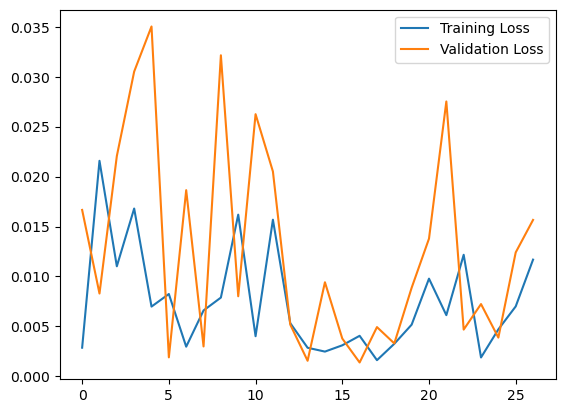

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

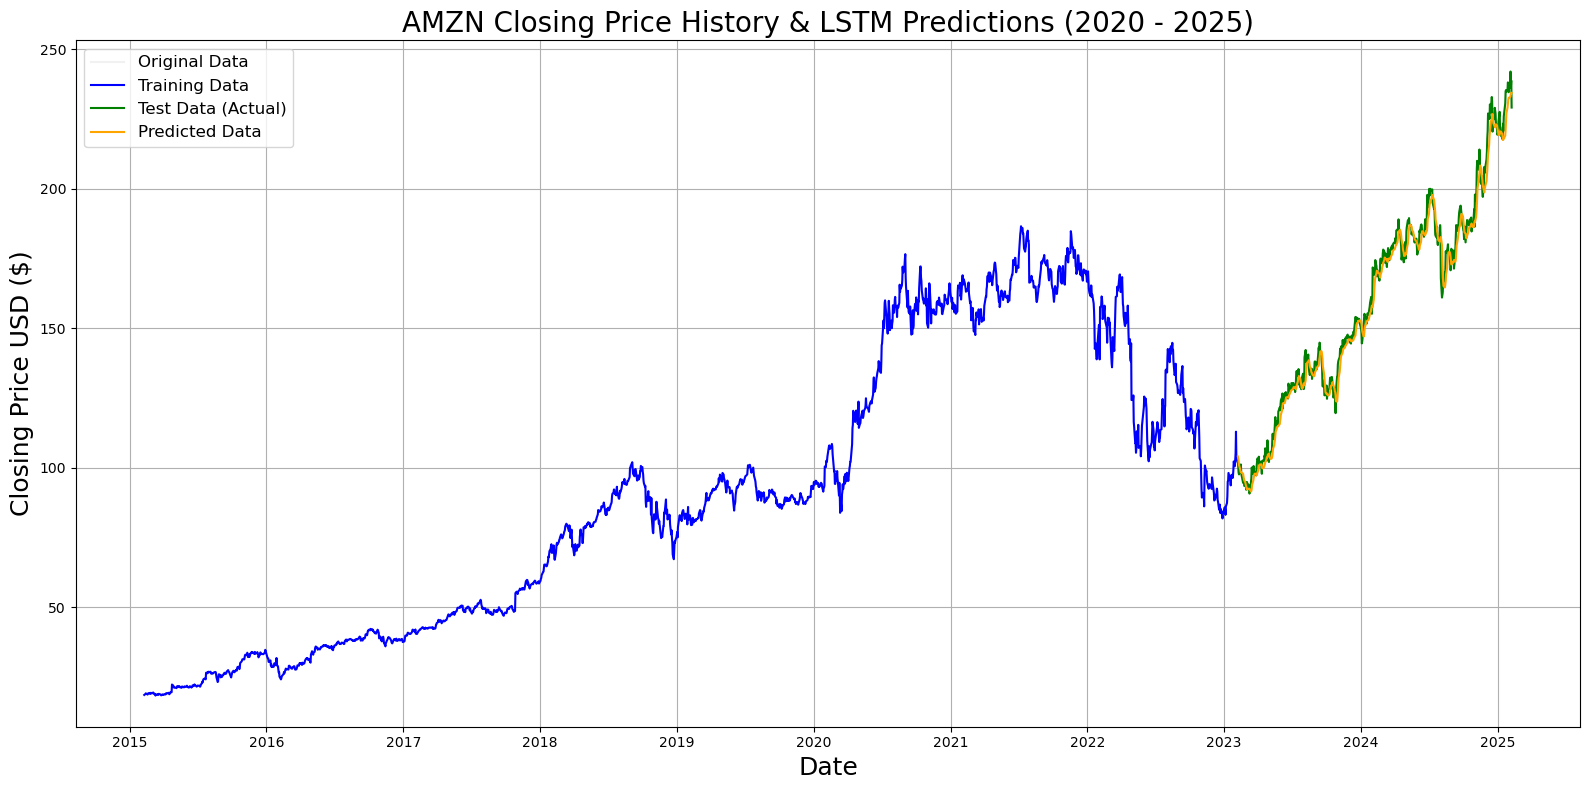

In [43]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('AMZN Closing Price History & LSTM Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### GRU TUNING

In [45]:
# ---------------------------
# Define GRU model builder
# ---------------------------
def build_gru_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_gru_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]   
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [01:06<54:26, 66.66s/it]

RMSE: 9.6876, R²: 0.9340

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [01:53<44:04, 55.08s/it]

RMSE: 8.9930, R²: 0.9431

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [02:38<39:27, 50.38s/it]

RMSE: 3.9531, R²: 0.9890

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [03:33<40:05, 52.29s/it]

RMSE: 25.0694, R²: 0.5579

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [04:25<39:10, 52.23s/it]

RMSE: 9.7297, R²: 0.9334

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [04:52<32:03, 43.71s/it]

RMSE: 24.9951, R²: 0.5606

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [05:17<26:55, 37.58s/it]

RMSE: 4.3341, R²: 0.9868

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [06:23<32:30, 46.43s/it]

RMSE: 7.9002, R²: 0.9561

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [07:10<31:50, 46.60s/it]

RMSE: 7.3741, R²: 0.9618

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [07:46<28:50, 43.26s/it]

RMSE: 8.7784, R²: 0.9458

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [08:12<24:48, 38.17s/it]

RMSE: 23.4282, R²: 0.6139

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [08:39<22:00, 34.74s/it]

RMSE: 41.8306, R²: -0.2308

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [09:01<19:03, 30.90s/it]

RMSE: 40.7354, R²: -0.1672

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [10:10<25:28, 42.46s/it]

RMSE: 5.3086, R²: 0.9802

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [10:36<21:51, 37.48s/it]

RMSE: 31.2876, R²: 0.3114

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [11:13<21:06, 37.24s/it]

RMSE: 12.7391, R²: 0.8859

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [11:33<17:42, 32.18s/it]

RMSE: 33.1189, R²: 0.2285

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [12:03<16:42, 31.32s/it]

RMSE: 38.9077, R²: -0.0648

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [12:54<19:15, 37.29s/it]

RMSE: 4.2768, R²: 0.9871

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [14:01<23:04, 46.15s/it]

RMSE: 4.1727, R²: 0.9878

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [14:29<19:45, 40.87s/it]

RMSE: 4.9642, R²: 0.9827

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [14:49<16:10, 34.67s/it]

RMSE: 41.8134, R²: -0.2298

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [15:53<19:26, 43.20s/it]

RMSE: 49.8446, R²: -0.7476

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [16:39<19:12, 44.32s/it]

RMSE: 50.3240, R²: -0.7813

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [17:35<19:51, 47.67s/it]

RMSE: 35.8655, R²: 0.0952

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [18:06<17:05, 42.74s/it]

RMSE: 5.7150, R²: 0.9770

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [18:45<15:57, 41.64s/it]

RMSE: 3.7944, R²: 0.9899

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [20:03<19:16, 52.56s/it]

RMSE: 43.5458, R²: -0.3338

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [21:34<22:25, 64.08s/it]

RMSE: 6.2535, R²: 0.9725

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [22:11<18:34, 55.75s/it]

RMSE: 9.7898, R²: 0.9326

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [22:48<15:54, 50.23s/it]

RMSE: 38.1364, R²: -0.0230

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [23:40<15:11, 50.64s/it]

RMSE: 7.9488, R²: 0.9556

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [23:59<11:40, 41.22s/it]

RMSE: 29.5879, R²: 0.3842

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [24:24<09:41, 36.37s/it]

RMSE: 19.2096, R²: 0.7404

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [24:58<08:54, 35.65s/it]

RMSE: 7.2369, R²: 0.9632

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [25:40<08:48, 37.73s/it]

RMSE: 4.1662, R²: 0.9878

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [26:15<07:58, 36.79s/it]

RMSE: 29.4241, R²: 0.3910

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [26:52<07:23, 36.92s/it]

RMSE: 29.8573, R²: 0.3730

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [27:59<08:24, 45.84s/it]

RMSE: 4.0424, R²: 0.9885

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [28:23<06:33, 39.38s/it]

RMSE: 18.0006, R²: 0.7721

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [29:07<06:05, 40.64s/it]

RMSE: 34.6956, R²: 0.1533

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [29:41<05:08, 38.61s/it]

RMSE: 38.5156, R²: -0.0434

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [30:20<04:32, 38.91s/it]

RMSE: 7.8458, R²: 0.9567

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [30:45<03:27, 34.65s/it]

RMSE: 26.0160, R²: 0.5239

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [31:19<02:52, 34.56s/it]

RMSE: 29.9061, R²: 0.3709

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [31:45<02:07, 31.95s/it]

RMSE: 4.3710, R²: 0.9866

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [33:11<02:24, 48.04s/it]

RMSE: 9.6768, R²: 0.9341

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [33:39<01:24, 42.18s/it]

RMSE: 5.9572, R²: 0.9750

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [34:23<00:42, 42.69s/it]

RMSE: 34.5084, R²: 0.1624

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [36:08<00:00, 43.37s/it]

RMSE: 9.5614, R²: 0.9357

Best Parameters:
validation_split                                                  0.2
units                                                              64
lr                                                              0.001
epochs                                                             50
dropout                                                           0.3
batch_size                                                         32
rmse                                                          3.79436
r2                                                           0.989873
val_loss                                                      0.00168
train_loss                                                   0.001679
preds               [104.46459, 103.20405, 101.68849, 99.996284, 9...
y_true              [102.11000061035156, 100.0500030517578, 98.239...
Name: 26, dtype: object
Best RMSE: 3.7944
Best R²: 0.9899


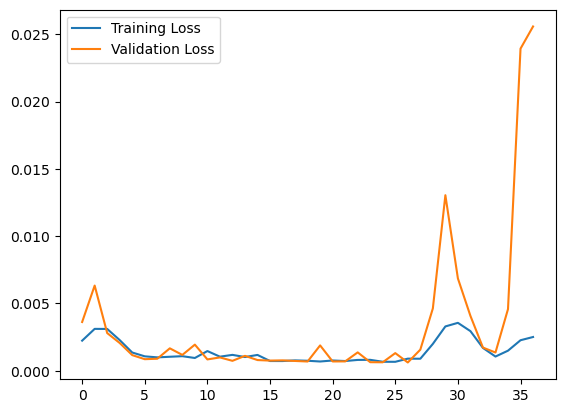

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

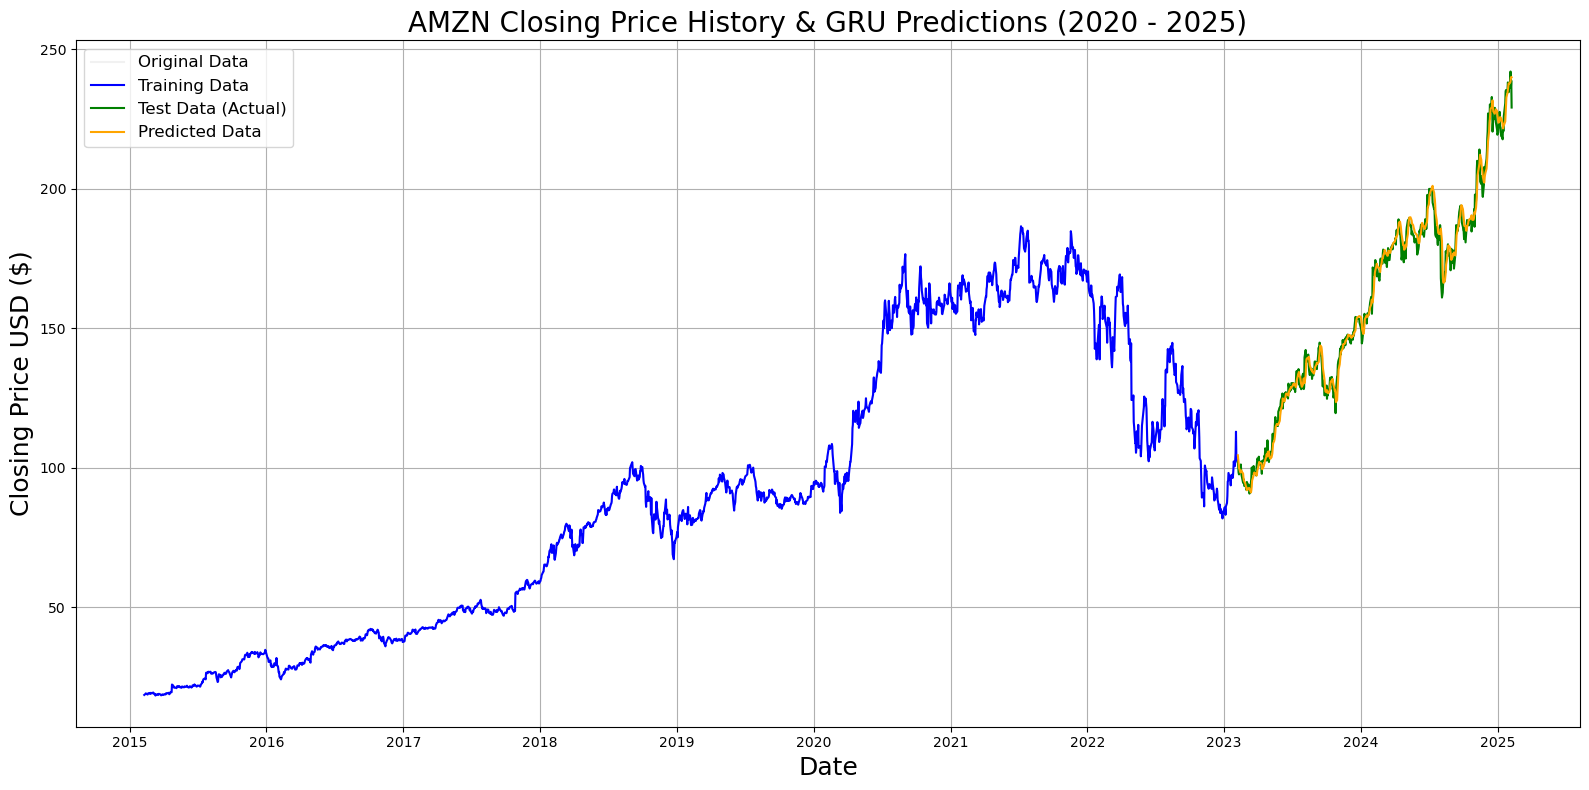

In [47]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('AMZN Closing Price History & GRU Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### HYBRID LSTM-GRU

In [49]:
# ---------------------------
# Define LSTM-GRU model builder
# ---------------------------
def build_lstm_gru_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_lstm_gru_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback] 
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:30<24:59, 30.61s/it]

RMSE: 18.8160, R²: 0.7510

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [01:14<30:52, 38.58s/it]

RMSE: 10.1342, R²: 0.9278

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [01:57<31:48, 40.61s/it]

RMSE: 10.6652, R²: 0.9200

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [03:14<42:06, 54.93s/it]

RMSE: 40.4177, R²: -0.1491

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [03:47<35:13, 46.96s/it]

RMSE: 13.9179, R²: 0.8637

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [04:13<29:11, 39.80s/it]

RMSE: 36.8461, R²: 0.0451

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [04:55<28:59, 40.44s/it]

RMSE: 6.7188, R²: 0.9682

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [05:29<26:59, 38.56s/it]

RMSE: 7.4024, R²: 0.9615

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [06:04<25:30, 37.34s/it]

RMSE: 8.6593, R²: 0.9473

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [06:50<26:36, 39.91s/it]

RMSE: 10.1149, R²: 0.9280

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [07:15<23:05, 35.51s/it]

RMSE: 29.7261, R²: 0.3785

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [07:47<21:43, 34.30s/it]

RMSE: 28.7452, R²: 0.4188

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [08:14<19:51, 32.21s/it]

RMSE: 36.2481, R²: 0.0758

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [08:50<20:00, 33.34s/it]

RMSE: 8.0078, R²: 0.9549

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [09:17<18:25, 31.58s/it]

RMSE: 36.9293, R²: 0.0407

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [09:46<17:23, 30.70s/it]

RMSE: 9.8742, R²: 0.9314

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [10:09<15:33, 28.28s/it]

RMSE: 37.9734, R²: -0.0143

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [10:49<17:03, 31.99s/it]

RMSE: 29.5084, R²: 0.3875

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [11:28<17:35, 34.06s/it]

RMSE: 5.6754, R²: 0.9773

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [12:16<19:07, 38.24s/it]

RMSE: 5.0024, R²: 0.9824

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [12:36<15:47, 32.68s/it]

RMSE: 7.7138, R²: 0.9581

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [13:08<15:10, 32.50s/it]

RMSE: 32.5023, R²: 0.2569

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [13:49<15:46, 35.07s/it]

RMSE: 41.4005, R²: -0.2056

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [14:32<16:10, 37.34s/it]

RMSE: 46.1490, R²: -0.4980

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [16:01<22:04, 52.99s/it]

RMSE: 43.9420, R²: -0.3582

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [16:42<19:40, 49.21s/it]

RMSE: 6.9450, R²: 0.9661

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [17:12<16:41, 43.56s/it]

RMSE: 9.6462, R²: 0.9346

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [17:57<16:10, 44.09s/it]

RMSE: 45.6303, R²: -0.4645

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [20:06<24:20, 69.56s/it]

RMSE: 4.2725, R²: 0.9872

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [20:40<19:33, 58.66s/it]

RMSE: 9.5235, R²: 0.9362

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [21:22<17:01, 53.74s/it]

RMSE: 44.3727, R²: -0.3849

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [22:00<14:44, 49.13s/it]

RMSE: 10.6420, R²: 0.9203

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [22:32<12:25, 43.87s/it]

RMSE: 6.3264, R²: 0.9718

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [23:01<10:32, 39.54s/it]

RMSE: 28.5003, R²: 0.4287

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [23:27<08:53, 35.54s/it]

RMSE: 12.5334, R²: 0.8895

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [24:07<08:36, 36.88s/it]

RMSE: 5.7127, R²: 0.9770

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [25:17<10:06, 46.67s/it]

RMSE: 35.9247, R²: 0.0922

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [26:00<09:06, 45.52s/it]

RMSE: 35.2995, R²: 0.1235

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [28:16<13:18, 72.61s/it]

RMSE: 5.7495, R²: 0.9767

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [28:57<10:31, 63.17s/it]

RMSE: 28.0516, R²: 0.4465

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [29:22<07:46, 51.87s/it]

RMSE: 27.0620, R²: 0.4849

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [29:58<06:15, 46.94s/it]

RMSE: 40.9940, R²: -0.1820

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [30:30<04:58, 42.63s/it]

RMSE: 9.5194, R²: 0.9363

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [30:53<03:39, 36.54s/it]

RMSE: 12.9925, R²: 0.8813

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [31:51<03:34, 42.96s/it]

RMSE: 39.1382, R²: -0.0774

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [32:29<02:47, 41.75s/it]

RMSE: 6.8760, R²: 0.9667

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [33:44<02:35, 51.69s/it]

RMSE: 10.0123, R²: 0.9295

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [34:14<01:30, 45.14s/it]

RMSE: 15.4475, R²: 0.8322

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [35:40<00:57, 57.42s/it]

RMSE: 48.3935, R²: -0.6473

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [37:09<00:00, 44.58s/it]

RMSE: 16.0606, R²: 0.8186

Best Parameters:
validation_split                                                  0.2
units                                                              50
lr                                                              0.001
epochs                                                             50
dropout                                                           0.2
batch_size                                                         16
rmse                                                         4.272536
r2                                                            0.98716
val_loss                                                     0.001124
train_loss                                                    0.00088
preds               [103.12771, 102.09248, 100.69452, 99.095024, 9...
y_true              [102.11000061035156, 100.0500030517578, 98.239...
Name: 28, dtype: object
Best RMSE: 4.2725
Best R²: 0.9872


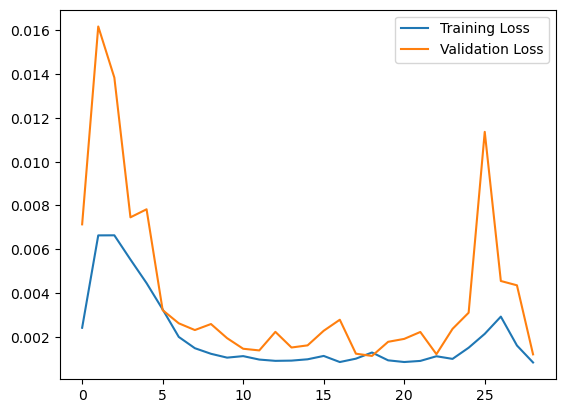

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

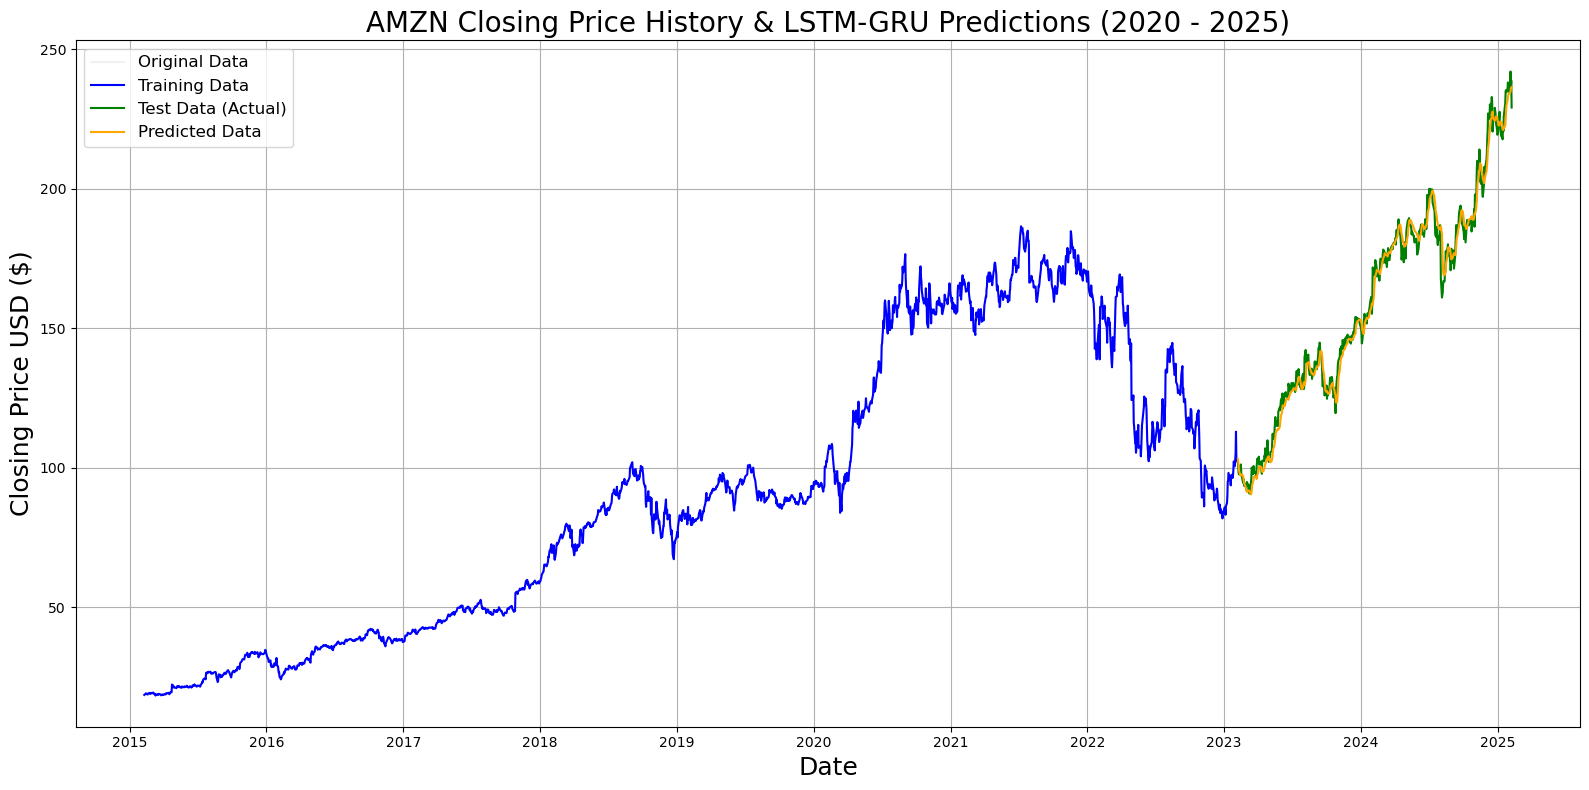

In [51]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('AMZN Closing Price History & LSTM-GRU Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### HYBRID GRU-LSTM

In [53]:
# ---------------------------
# Define GRU-LSTM model builder
# ---------------------------
def build_gru_lstm_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_gru_lstm_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:34<28:03, 34.36s/it]

RMSE: 9.7355, R²: 0.9333

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [01:20<33:03, 41.32s/it]

RMSE: 9.0955, R²: 0.9418

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [02:47<48:37, 62.07s/it]

RMSE: 5.5080, R²: 0.9787

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [04:08<53:28, 69.74s/it]

RMSE: 43.2127, R²: -0.3135

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [04:38<41:27, 55.27s/it]

RMSE: 17.3931, R²: 0.7872

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [05:05<33:32, 45.73s/it]

RMSE: 28.1429, R²: 0.4429

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [05:45<31:26, 43.87s/it]

RMSE: 5.3692, R²: 0.9797

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [06:29<30:44, 43.91s/it]

RMSE: 9.8468, R²: 0.9318

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [06:57<26:34, 38.90s/it]

RMSE: 5.7287, R²: 0.9769

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [07:29<24:29, 36.73s/it]

RMSE: 14.2996, R²: 0.8562

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [07:59<22:38, 34.84s/it]

RMSE: 42.4929, R²: -0.2701

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [08:26<20:27, 32.29s/it]

RMSE: 36.4022, R²: 0.0679

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [08:59<20:06, 32.61s/it]

RMSE: 31.6935, R²: 0.2935

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [09:43<21:30, 35.85s/it]

RMSE: 8.6552, R²: 0.9473

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [10:05<18:34, 31.84s/it]

RMSE: 34.7435, R²: 0.1509

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [10:47<19:45, 34.88s/it]

RMSE: 5.9128, R²: 0.9754

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [11:25<19:39, 35.74s/it]

RMSE: 18.2090, R²: 0.7668

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [11:55<18:07, 33.99s/it]

RMSE: 31.3499, R²: 0.3087

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [13:50<30:05, 58.24s/it]

RMSE: 3.3241, R²: 0.9922

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [14:34<27:03, 54.13s/it]

RMSE: 5.4856, R²: 0.9788

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [14:58<21:44, 44.97s/it]

RMSE: 6.4317, R²: 0.9709

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [15:26<18:43, 40.11s/it]

RMSE: 72.5598, R²: -2.7033

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [16:04<17:44, 39.42s/it]

RMSE: 38.7852, R²: -0.0581

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [16:46<17:23, 40.15s/it]

RMSE: 46.5043, R²: -0.5212

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [18:14<22:40, 54.43s/it]

RMSE: 43.5055, R²: -0.3313

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [19:02<20:57, 52.41s/it]

RMSE: 6.1770, R²: 0.9732

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [19:50<19:36, 51.17s/it]

RMSE: 7.5546, R²: 0.9599

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [20:26<17:05, 46.62s/it]

RMSE: 45.2873, R²: -0.4426

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [21:04<15:26, 44.13s/it]

RMSE: 5.2946, R²: 0.9803

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [21:25<12:21, 37.07s/it]

RMSE: 11.3787, R²: 0.9089

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [21:52<10:50, 34.21s/it]

RMSE: 39.7068, R²: -0.1090

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [22:27<10:20, 34.47s/it]

RMSE: 12.1066, R²: 0.8969

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [22:56<09:17, 32.80s/it]

RMSE: 6.9152, R²: 0.9664

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [23:44<09:57, 37.34s/it]

RMSE: 10.0082, R²: 0.9295

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [24:03<07:56, 31.77s/it]

RMSE: 9.9648, R²: 0.9302

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [24:47<08:15, 35.41s/it]

RMSE: 7.5611, R²: 0.9598

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [25:19<07:29, 34.56s/it]

RMSE: 49.6357, R²: -0.7329

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [25:53<06:51, 34.29s/it]

RMSE: 38.4703, R²: -0.0410

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [27:03<08:15, 45.05s/it]

RMSE: 5.1954, R²: 0.9810

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [27:31<06:37, 39.73s/it]

RMSE: 12.3035, R²: 0.8935

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [27:47<04:54, 32.77s/it]

RMSE: 40.8126, R²: -0.1716

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [28:11<03:59, 29.99s/it]

RMSE: 37.3307, R²: 0.0198

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [28:29<03:06, 26.65s/it]

RMSE: 15.7697, R²: 0.8251

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [28:51<02:30, 25.11s/it]

RMSE: 15.3072, R²: 0.8352

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [29:44<02:47, 33.58s/it]

RMSE: 43.4335, R²: -0.3269

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [30:04<01:57, 29.39s/it]

RMSE: 4.7150, R²: 0.9844

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [30:33<01:28, 29.35s/it]

RMSE: 10.2605, R²: 0.9259

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [30:51<00:52, 26.03s/it]

RMSE: 12.9210, R²: 0.8826

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [31:26<00:28, 28.53s/it]

RMSE: 39.8471, R²: -0.1168

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [32:04<00:00, 38.49s/it]

RMSE: 14.3684, R²: 0.8548

Best Parameters:
validation_split                                                  0.2
units                                                              32
lr                                                              0.001
epochs                                                             50
dropout                                                           0.1
batch_size                                                         16
rmse                                                         3.324085
r2                                                           0.992228
val_loss                                                     0.002431
train_loss                                                    0.00102
preds               [104.43226, 103.85312, 102.3667, 100.781715, 9...
y_true              [102.11000061035156, 100.0500030517578, 98.239...
Name: 18, dtype: object
Best RMSE: 3.3241
Best R²: 0.9922


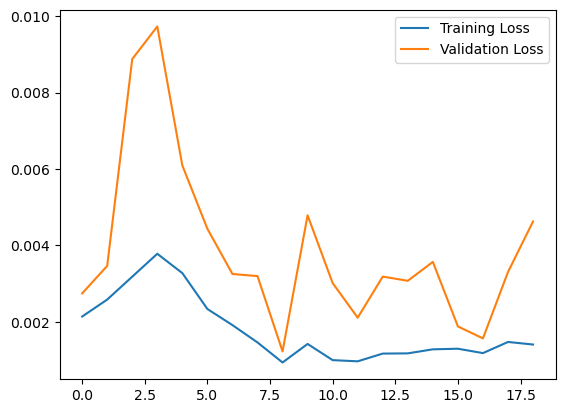

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

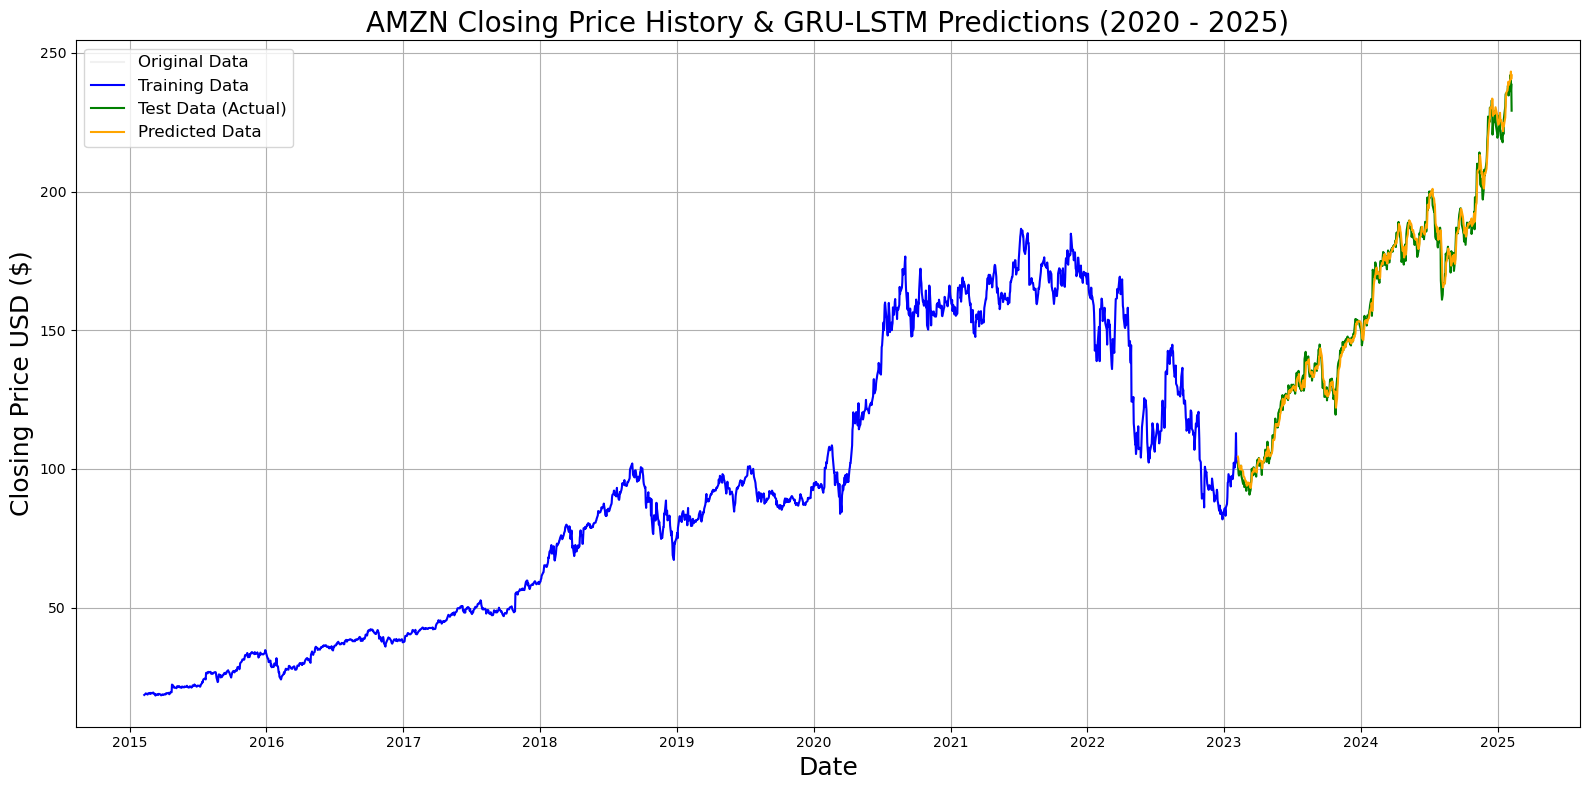

In [55]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('AMZN Closing Price History & GRU-LSTM Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()